#Sentiment Analysis on IMDb Movie Reviews

##Step 1

In [ ]:
!pip install tensorflow


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the IMDb reviews dataset
(train_data, test_data), info = tfds.load(
    "imdb_reviews",
    split=(tfds.Split.TRAIN, tfds.Split.TEST),
    with_info=True,
    as_supervised=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2CDTNK/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2CDTNK/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2CDTNK/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Print some example reviews and labels
for example, label in train_data.take(5):
    print('Review:', example.numpy())
    print('Label:', label.numpy())


Review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label: 0
Review: b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish.

##Step 2

In [ ]:
!pip install nltk

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import numpy as np

# Download necessary resources
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and define stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert bytes to string if necessary
    if isinstance(text, bytes):
        text = text.decode('utf-8')

    # Lowercase the text
    text = text.lower()

    # Remove punctuation, numbers and special characters
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])

    # Remove stop words and lemmatize
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(text)

# Apply the cleaning function to both train and test datasets
train_cleaned = [(clean_text(example.numpy()), label.numpy()) for example, label in train_data]
test_cleaned = [(clean_text(example.numpy()), label.numpy()) for example, label in test_data]

# Checking if the data is balanced
labels = [label for _, label in train_cleaned]
print(f"Positive reviews: {np.sum(labels)}")
print(f"Negative reviews: {len(labels) - np.sum(labels)}")

# If not balanced, you might consider undersampling, oversampling or using SMOTE.
# For this example, I'll assume the dataset is balanced as the IMDb dataset typically is.

# Let's print some cleaned reviews
for review, label in train_cleaned[:5]:
    print('Review:', review)
    print('Label:', label)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Positive reviews: 12500
Negative reviews: 12500
Review: absolutely terrible movie dont lured christopher walken michael ironside great actor must simply worst role history even great acting could redeem movie ridiculous storyline movie early ninety u propaganda piece pathetic scene columbian rebel making case revolution maria conchita alonso appeared phony pseudolove affair walken nothing pathetic emotional plug movie devoid real meaning disappointed movie like ruining actor like christopher walkens good name could barely sit
Label: 0
Review: known fall asleep film usually due combination thing including really tired warm comfortable sette eaten lot however occasion fell asleep film rubbish plot development constant constantly slow boring thing seemed happen explanation causing admit may missed part film watched majority everything seemed happen accord without real concern anything else cant recommend film
Label: 0
Review: mann photograph alberta rocky mountain superb fashion jimmy ste

##Step 3

###**Algorithm-Specific Feature Extraction:**

###Logistic Regression:

Vectorization: Convert tokens into vectors using methods like:
Count Vectorization: Represent text based on the frequency of words.
TF-IDF (Term Frequency-Inverse Document Frequency): Weigh words based on their importance in the document relative to the entire dataset.
Feature Selection: Depending on the dataset size, you might want to keep only the top N most informative words/n-grams.

###LSTM or BiLSTM:

Embeddings: Convert tokens into dense vectors using embeddings. You can:
Train your own embeddings.
Use pre-trained embeddings like Word2Vec, GloVe, or embeddings from models like BERT.
Sequence Padding: LSTMs require input sequences to be of the same length. So, you'll need to pad shorter sequences and truncate longer ones.

###Ensemble Methods:

Similar to Logistic Regression, you'll convert tokens into vectors. However, since tree-based methods can handle a larger number of features without as much risk of overfitting (especially Random Forests), you might opt for a larger feature set.
Often, simpler vectorization methods like Count Vectorization work well. But TF-IDF can also be beneficial.

###3.1 : Logistic Regression:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Split the cleaned data
reviews = [review for review, _ in train_cleaned]
labels = [label for _, label in train_cleaned]

X_train, X_val, y_train, y_val = train_test_split(reviews, labels, test_size=0.2, random_state=42)

# Using Count Vectorizer
count_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1,2))
X_train_count = count_vectorizer.fit_transform(X_train)
X_val_count = count_vectorizer.transform(X_val)

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Optionally, for feature selection to keep the top N most informative words/n-grams
TOP_K = 5000  # Adjust based on how many top features you want to keep

# Note: Using f_classif here for feature selection
selector = SelectKBest(f_classif, k=min(TOP_K, X_train_count.shape[1]))
X_train_count_selected = selector.fit_transform(X_train_count, y_train)
X_val_count_selected = selector.transform(X_val_count)

# Do the same for TF-IDF if needed
selector_tfidf = SelectKBest(f_classif, k=min(TOP_K, X_train_tfidf.shape[1]))
X_train_tfidf_selected = selector_tfidf.fit_transform(X_train_tfidf, y_train)
X_val_tfidf_selected = selector_tfidf.transform(X_val_tfidf)

print("Count Vectorization:", X_train_count.shape)
print("Count Vectorization after feature selection:", X_train_count_selected.shape)
print("TF-IDF Vectorization:", X_train_tfidf.shape)
print("TF-IDF Vectorization after feature selection:", X_train_tfidf_selected.shape)


Count Vectorization: (20000, 10000)
Count Vectorization after feature selection: (20000, 5000)
TF-IDF Vectorization: (20000, 10000)
TF-IDF Vectorization after feature selection: (20000, 5000)


In [ ]:
# Train a Logistic Regression model on Count Vectorizer features
clf_count = LogisticRegression(max_iter=1000)
clf_count.fit(X_train_count_selected, y_train)

# Predict on validation set
y_pred_count = clf_count.predict(X_val_count_selected)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred_count)
precision = precision_score(y_val, y_pred_count)
recall = recall_score(y_val, y_pred_count)
f1 = f1_score(y_val, y_pred_count)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_count))

# You can repeat the same for the TF-IDF features if desired.


Accuracy: 0.8638
Precision: 0.8501
Recall: 0.8729
F1 Score: 0.8614

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      2576
           1       0.85      0.87      0.86      2424

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



###3.2 : LSTM or BiLSTM:

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report

# Tokenization and padding
MAX_LEN = 100  # Define the maximum length for sequences
VOCAB_SIZE = 10000  # Define the size of your vocabulary

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, truncating='post', padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, truncating='post', padding='post')

# Define LSTM model
model = Sequential([
    Embedding(VOCAB_SIZE, 128, input_length=MAX_LEN),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
model.summary()

# Convert y_train and y_val to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

# Now train the model
history = model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_val_pad, y_val))

# Continue with the rest of the code...


# Predict on validation set
y_pred_val = (model.predict(X_val_pad) > 0.5).astype('int32').reshape(-1)

# Evaluate using our metrics
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 lstm_2 (LSTM)               (None, 100, 128)          131584    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1543297 (5.89 MB)
Trainable params: 1543297 (5.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
625/625 [==============================] - 206s 323ms/step - loss: 0.5597 - accuracy: 0.7078 - precision_1: 0.6848 - recall_1: 0.7779 - va

###3.3 : Ensemble Methods:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # We limit to 5000 most frequent words for demonstration
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Train a Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train_tfidf, y_train)

# Predict on validation set
y_pred_rf = rf_clf.predict(X_val_tfidf)

# Evaluation
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_rf))


Random Forest Accuracy: 0.8410

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      2576
           1       0.84      0.83      0.84      2424

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



###Model Comparision

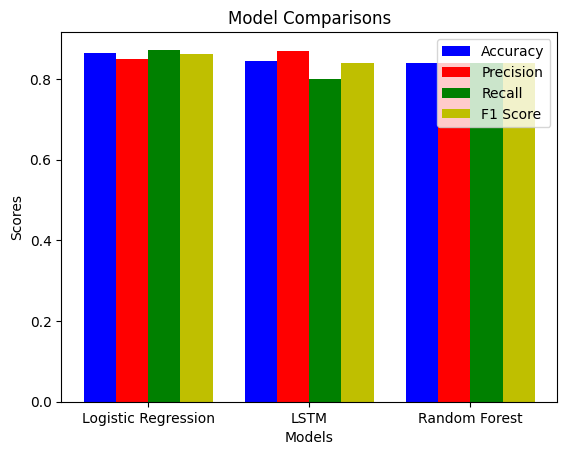

In [ ]:
import matplotlib.pyplot as plt

# Data to plot
models = ['Logistic Regression', 'LSTM', 'Random Forest']
accuracy = [0.8638, 0.8448, 0.8410]
precision = [0.8501, 0.87, 0.84]
recall = [0.8729, 0.80, 0.84]
f1 = [0.8614, 0.84, 0.84]

# Plotting the bar graph
x = range(len(models))
plt.bar(x, accuracy, width=0.2, align='center', label='Accuracy', color='b')
plt.bar([i + 0.2 for i in x], precision, width=0.2, align='center', label='Precision', color='r')
plt.bar([i + 0.4 for i in x], recall, width=0.2, align='center', label='Recall', color='g')
plt.bar([i + 0.6 for i in x], f1, width=0.2, align='center', label='F1 Score', color='y')

# Adding labels
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparisons')
plt.xticks([i + 0.3 for i in x], models)
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Creating the DataFrame
df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

print(df)


                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression    0.8638     0.8501  0.8729    0.8614
1                 LSTM    0.8448     0.8700  0.8000    0.8400
2        Random Forest    0.8410     0.8400  0.8400    0.8400


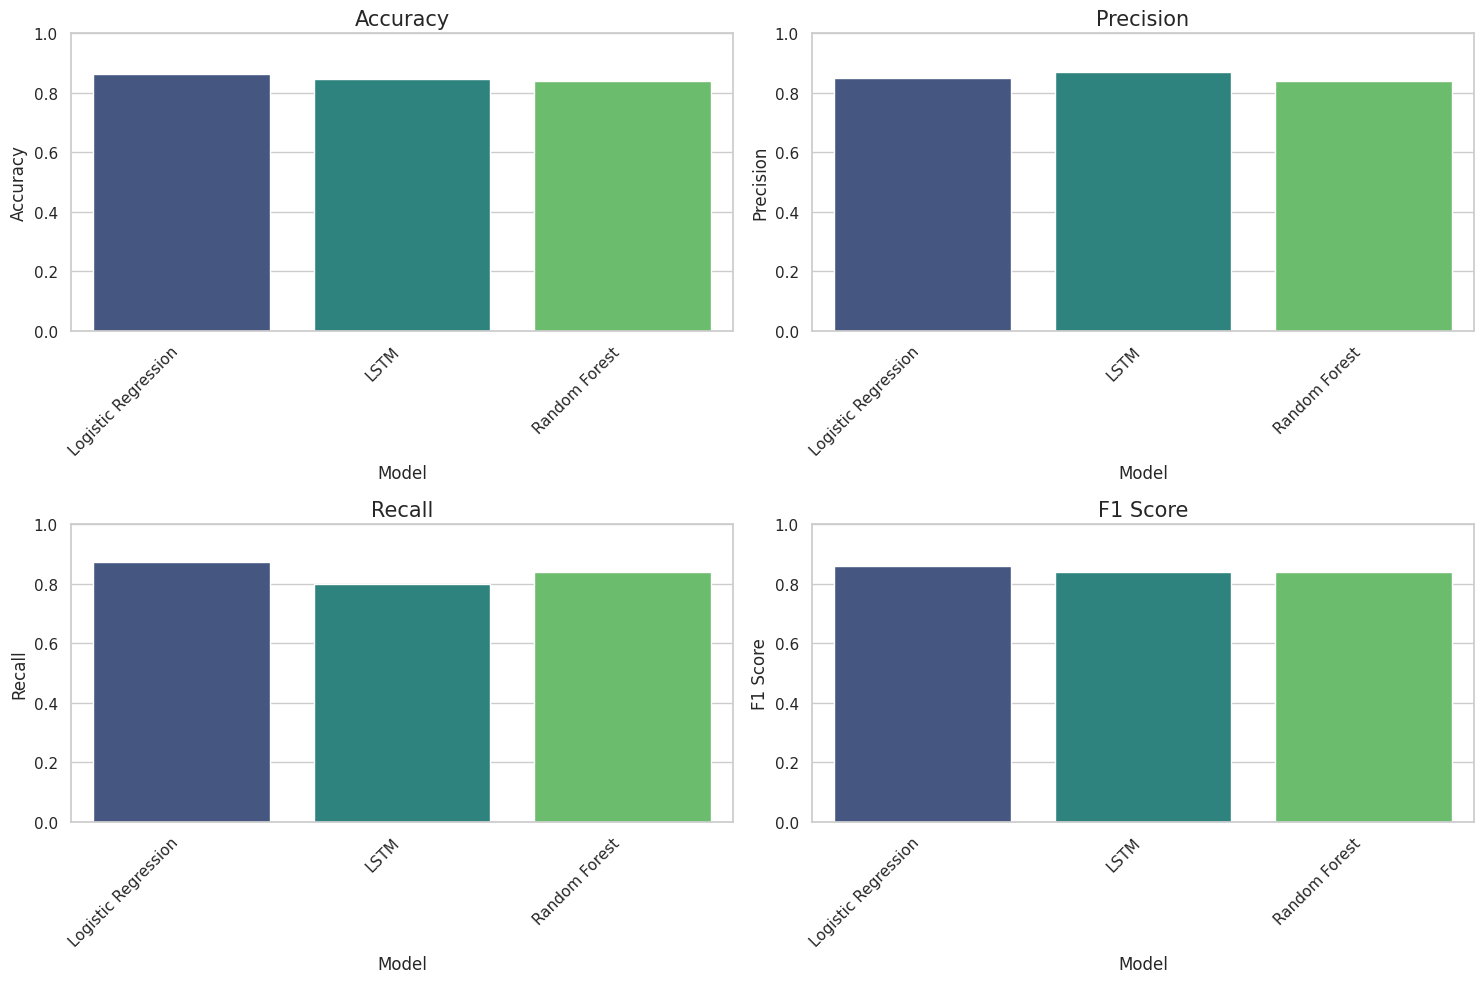

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting Seaborn's style
sns.set(style="whitegrid")

# Plotting the metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

for ax, metric in zip(axes.ravel(), metrics):
    sns.barplot(data=df, x='Model', y=metric, ax=ax, palette='viridis')
    ax.set_title(metric, fontsize=15)
    ax.set_ylim(0, 1)  # since all metrics are in the range [0, 1]
    ax.set_xticklabels(df['Model'], rotation=45, ha="right")

plt.tight_layout()
plt.show()


#EXTRA

In [ ]:
def get_top_features(vectorizer, model, n=10):
    feature_names = vectorizer.get_feature_names_out()
    coef = model.coef_[0]
    top_positive_coef_indices = coef.argsort()[-n:][::-1]
    top_negative_coef_indices = coef.argsort()[:n]

    top_positive_features = [(feature_names[i], coef[i]) for i in top_positive_coef_indices]
    top_negative_features = [(feature_names[i], coef[i]) for i in top_negative_coef_indices]

    return top_positive_features, top_negative_features

top_positive_features, top_negative_features = get_top_features(tfidf_vectorizer, clf_count)

print("Top positive indicative features:")
for feature, coef in top_positive_features:
    print(f"{feature}: {coef:.4f}")

print("\nTop negative indicative features:")
for feature, coef in top_negative_features:
    print(f"{feature}: {coef:.4f}")


Top positive indicative features:
begging: 1.9040
asylum: 1.6650
hopkins: 1.6429
henry fool: 1.6279
br reason: 1.6194
commentary: 1.5640
knee: 1.5582
badly written: 1.5231
immortal: 1.4939
comedian: 1.4920

Top negative indicative features:
brilliant: -2.3729
doesnt like: -2.1397
lackluster: -2.0126
clerk: -1.9799
film two: -1.9374
everything else: -1.9228
commented: -1.8354
enjoy film: -1.6465
gifted: -1.6153
invasion: -1.6079


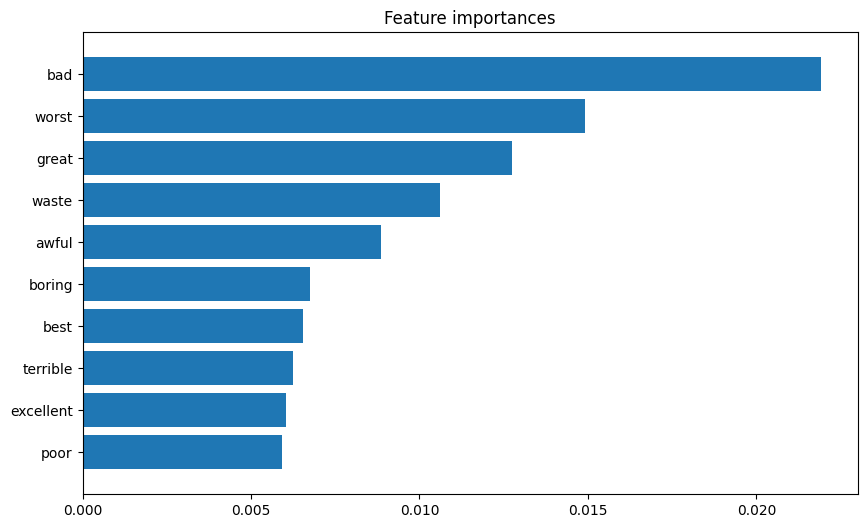

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_importances(vectorizer, model, n=10):
    feature_names = vectorizer.get_feature_names_out()
    importances = model.feature_importances_

    indices = np.argsort(importances)[-n:]

    plt.figure(figsize=(10, 6))
    plt.title("Feature importances")
    plt.barh(range(n), importances[indices], align="center")
    plt.yticks(range(n), [feature_names[i] for i in indices])
    plt.ylim([-1, n])
    plt.show()

plot_feature_importances(vectorizer, rf_clf)
